In [7]:
import os
import math
import sys
import glob
import pickle
import time

import warnings
warnings.filterwarnings('ignore')

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tqdm.notebook import tqdm

In [10]:
! pip install PyWavelets
import pywt


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
kind = 'all-cols-with-time'

In [12]:
variant = 'sine 750 mv'
pred_dir = os.path.join('predictions',variant)
metrics_dir = 'metrics'
rst_graph = os.path.join('graphs','outputs',variant)
metrics_graph = os.path.join('graphs','metrics',variant)

In [13]:
metric_file ='rf_inc_STITCHED-{}-{}.csv'.format(variant, kind)

In [14]:
train_loc = "D:\\Final Year Project\\Play with DWT\\Sine\\dataset\\{}\\train".format(variant)
test_loc = "D:\\Final Year Project\\Play with DWT\\Sine\\dataset\\{}\\test".format(variant)

In [15]:
test_files = glob.glob(test_loc + "\\*.csv")

regions = ['rise1', 'rise2', 'rise3', 'functional', 'fall']

for file_location in test_files:
    file_name = os.path.basename(file_location)
    df = pd.DataFrame()
    
    for region in regions:
        folder_path = os.path.join(pred_dir, region)
        file_path = folder_path + '\\' + file_name
        
        temp_df = pd.read_csv(file_path)
        df = df.append(temp_df, ignore_index = True)
        
    df.to_csv('{}/{}'.format(pred_dir, file_name), index = False)

In [16]:
df

,Time,actual vinn,predicted vinn
0,0,0.000000,0.000065
1,1,0.001576,0.001285
2,2,0.003152,0.002605
3,3,0.004728,0.004130
4,4,0.006304,0.005747
...,...,...,...
14996,14995,0.886538,0.881939
14997,14996,0.886583,0.881939
14998,14997,0.886629,0.881939
14999,14998,0.886675,0.881939


In [17]:
def SNR(y, y_pred):
    n = len(y)
    upper = 0
    lower = 0
    for ind in range(0,n):
        out = y.iloc[ind]
        pred_out = y_pred.iloc[ind]
        upper += (out ** 2)
        lower += (out - pred_out) ** 2
        
    snr = 10 * math.log10(upper / lower)
    return snr

In [18]:
def compute_metrics(file, m1):
    df_test = pd.read_csv(file)
    y_test = df_test['actual vinn']
    y_pred = df_test['predicted vinn']
    time = df_test['Time']
    
    p1 = pd.Series(y_pred)
    
    mae1 = mean_absolute_error(y_test, p1)

    mse1 = mean_squared_error(y_test, p1)

    r2_1 = r2_score(y_test, p1)

    snr1 = SNR(y_test,p1)

    rmse1 = math.sqrt(mse1)
        
    file_name = os.path.basename(file)
    metrics_1 = {'file_name' : file_name, 'RMSE':round(rmse1,4), 'MSE': round(mse1,4), 'MAE':round(mae1,4), 'R2':round(r2_1,4), 'SNR':round(snr1,4)}
    m1 = m1.append(metrics_1, ignore_index = True)
    
    return m1

In [19]:
i = 1

metrics_df = pd.DataFrame()
predictions = glob.glob(pred_dir + "\\*.csv")

for file in predictions:
    print("File : ",i)
    metrics_df = compute_metrics(file, metrics_df)
    print('-----------')
    i = i+1

File :  1
-----------
File :  2
-----------
File :  3
-----------
File :  4
-----------
File :  5
-----------
File :  6
-----------
File :  7
-----------
File :  8
-----------
File :  9
-----------
File :  10
-----------


In [20]:
metrics_df.to_csv(os.path.join(metrics_dir, metric_file), index = False)
metrics_df

,file_name,RMSE,MSE,MAE,R2,SNR
0,fastnfastp_3.3V_45.csv,0.0782,0.0061,0.0377,0.9865,24.7762
1,fastnfastp_3.6V_45.csv,0.0840,0.0071,0.0407,0.9842,24.1732
2,fastnslowp_3.3V_45.csv,0.0907,0.0082,0.0407,0.9827,23.2338
3,fastnslowp_3.6V_45.csv,0.0697,0.0049,0.0357,0.9897,25.6484
4,slownfastp_3.3V_45.csv,0.0584,0.0034,0.0313,0.9926,26.9772
5,slownfastp_3.6V_45.csv,0.0616,0.0038,0.0326,0.9918,26.5290
6,slownslowp_3.3V_45.csv,0.0470,0.0022,0.0212,0.9952,28.7324
7,slownslowp_3.6V_45.csv,0.0726,0.0053,0.0336,0.9885,25.0295
8,typical_3.3V_45.csv,0.0364,0.0013,0.0167,0.9971,31.1522
9,typical_3.6V_45.csv,0.0575,0.0033,0.0269,0.9927,27.2129


In [21]:
# Before executing this cell zip graphs_bag and download
def draw (file,name):
    df_fun=pd.read_csv(file)
    
    X_time=df_fun['Time']
    vinn = df_fun['actual vinn']
    pred_vinn = df_fun['predicted vinn']
    
    fig=plt.figure(figsize=(16,9), facecolor='w', edgecolor='k')
    plt.plot(X_time,vinn, color="red", linewidth=3, label = vinn)
    plt.plot(X_time,pred_vinn, color="blue", linewidth=3, label = pred_vinn)
    
    temp_values = {
        '-55':'-55T',
        '-35':'-35T',
        '-15':'-15T',
        '5':'5T',
        '25':'25T',
        '45':'45T',
        '65':'65T',
        '85':'85T',
        '105':'105T',
        '125':'125T',
    }
    
#     tokens = name.split('_')
#     temp = temp_values[tokens[-1][:-4]]
#     title =  "_".join(tokens[:-1] + [temp])
    title = name
    
    plt.xlabel("Time(ns)", fontsize=15)
    plt.ylabel("vinn", fontsize=15)
    plt.grid(True)
    plt.legend()
    plt.legend(["Actual vinn", "Predicted vinn"], loc ="lower right")
    plt.title(title)
    

    nm = rst_graph + '//' + 'stitched_' + title + ".jpg"
    plt.savefig(nm)

File  1
---------------
File  2
---------------
File  3
---------------
File  4
---------------
File  5
---------------
File  6
---------------
File  7
---------------
File  8
---------------
File  9
---------------
File  10
---------------


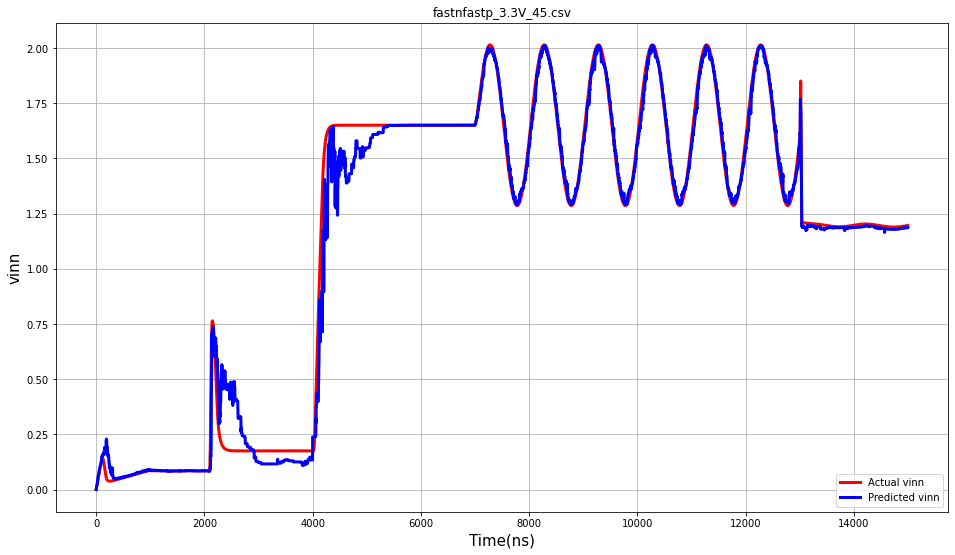

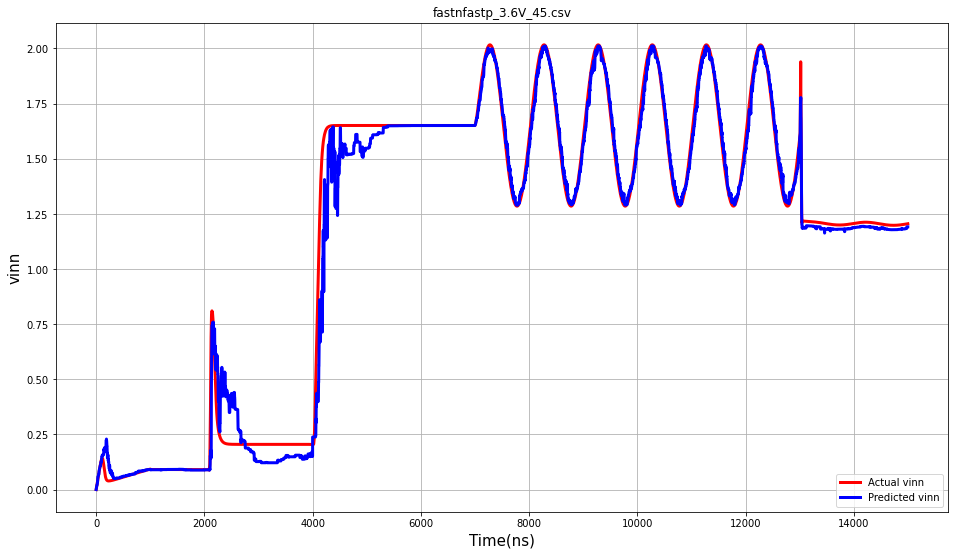

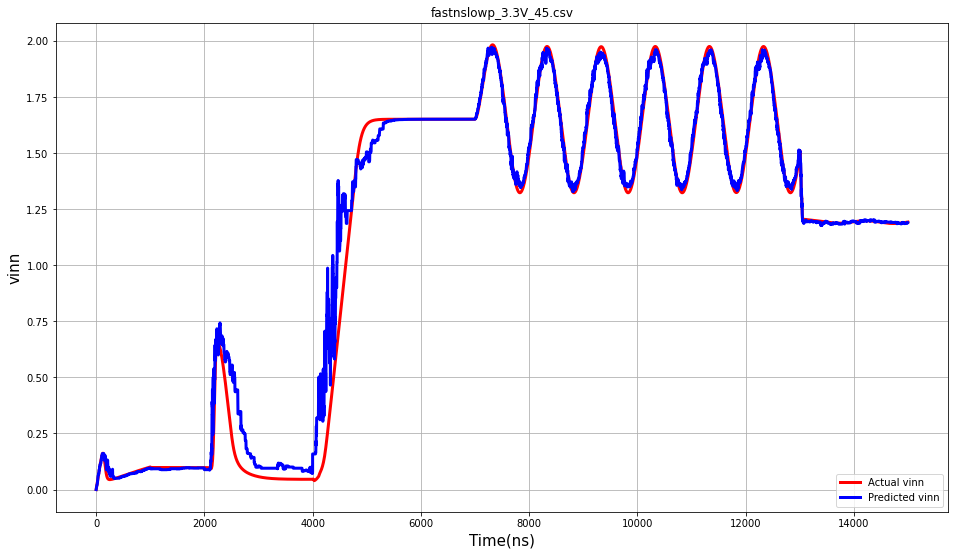

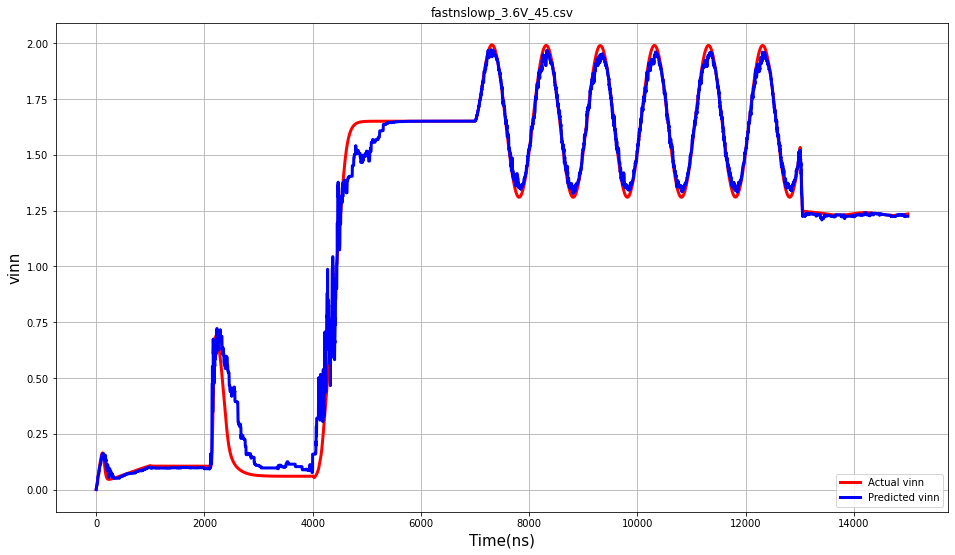

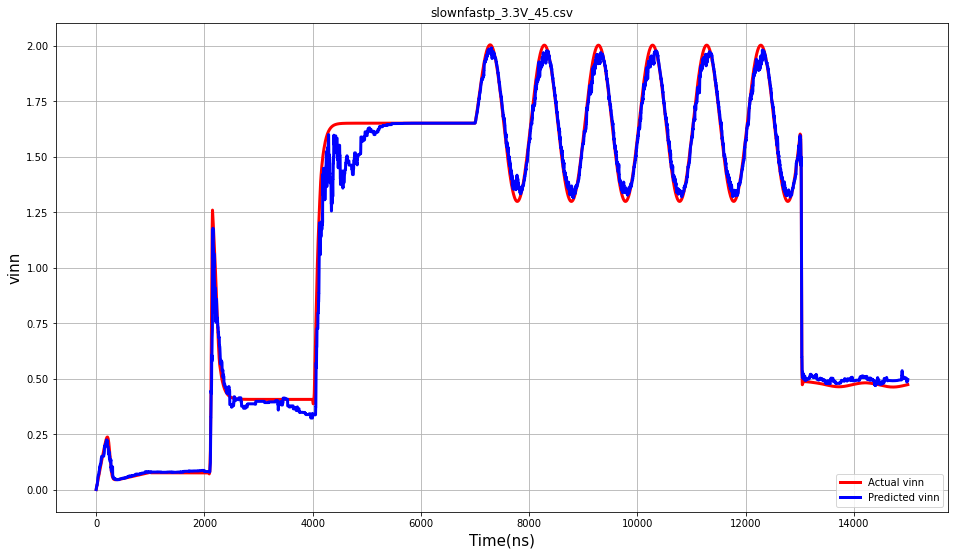

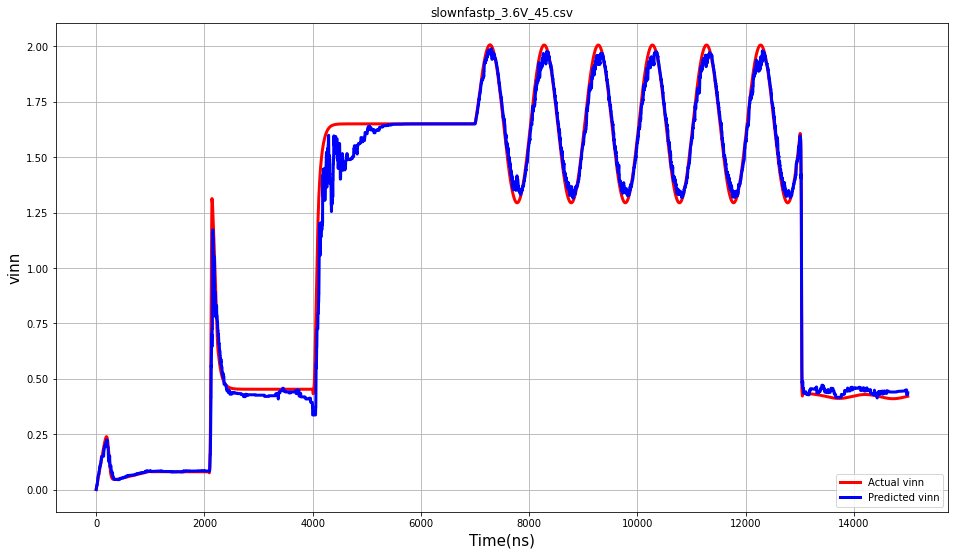

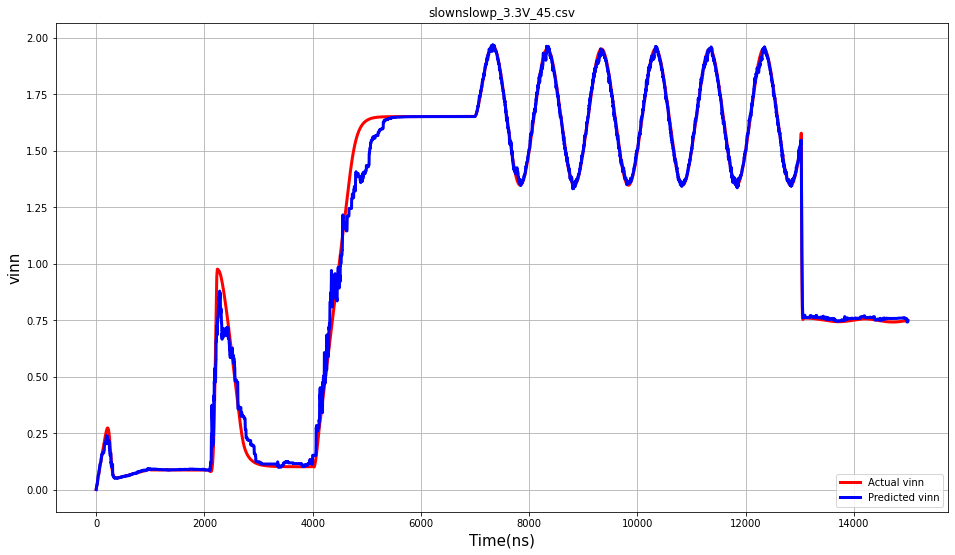

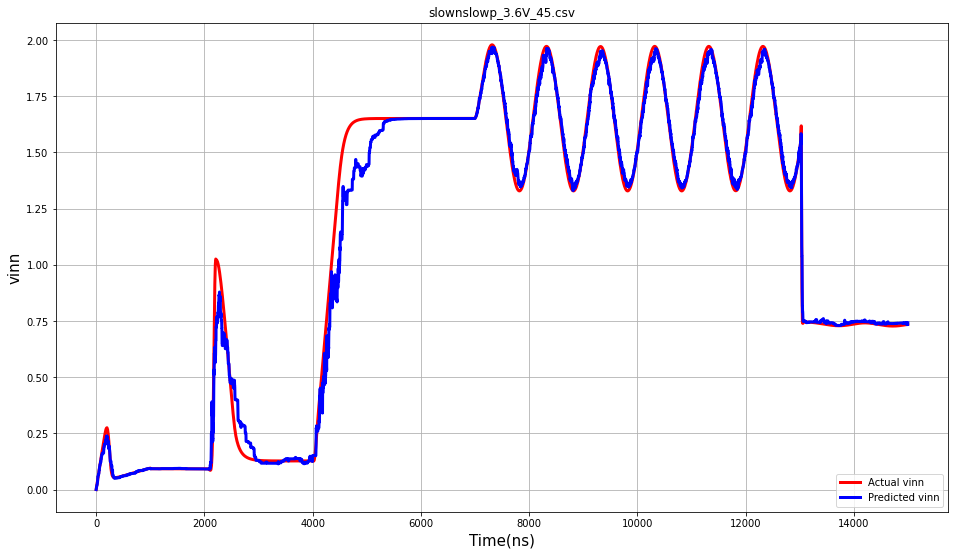

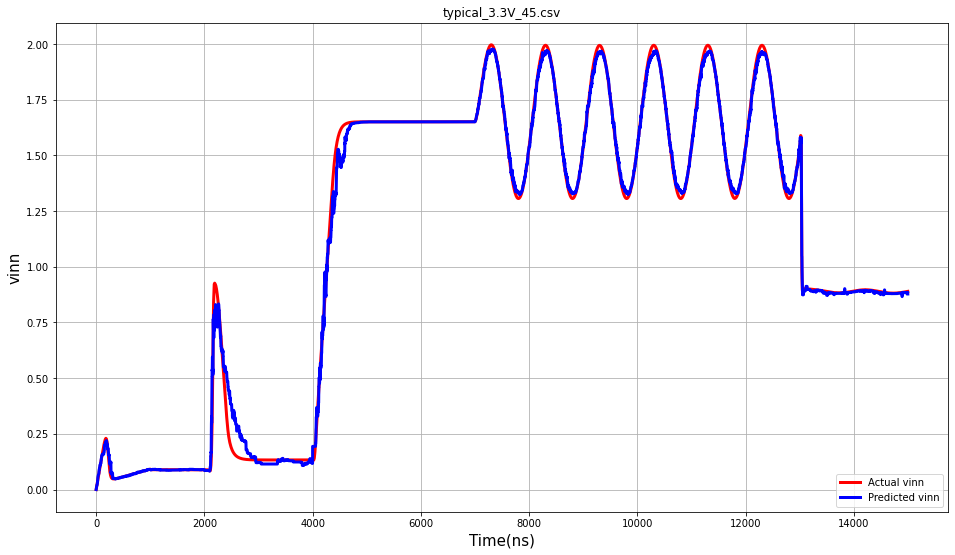

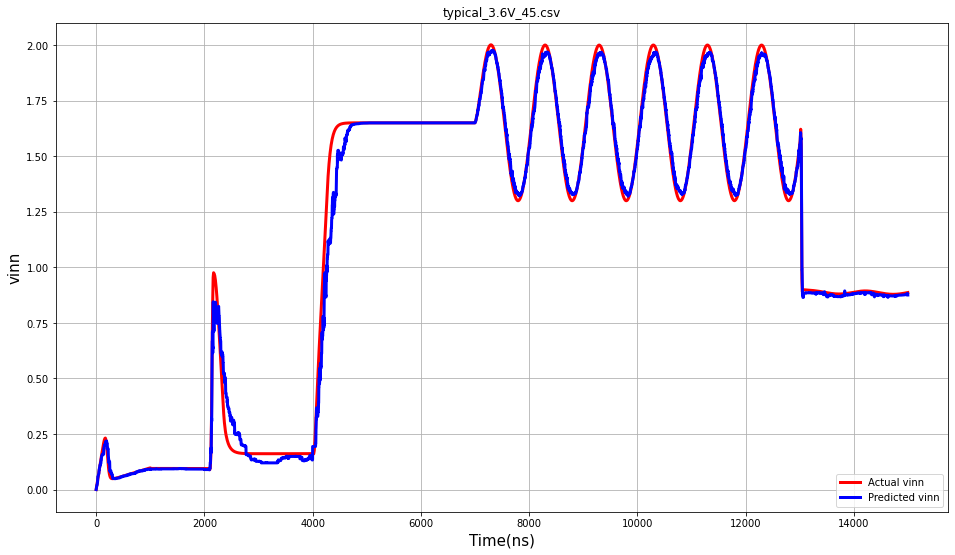

In [22]:
path = pred_dir + '//' + "*.csv"
count =0
for file in glob.glob(path):
    count = count+1
    print ("File ", count)
    print ("---------------")
    name = os.path.basename(file)
    draw(file,name)